In [1]:
from os.path import abspath
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [123]:
# create database
# File location and type
file_location_array = [
    {"location" : "../../training/pred_tremi_full.csv", "name": "pred_tremi_full", "delimiter": ","},
    {"location" :  "../../training/training_dpe.csv", "name": "training_dpe", "delimiter": ","},
    {"location" :  "../../training/prediction_dpe.csv", "name": "prediction_dpe", "delimiter": ","},
    {"location" :  "../../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type) \
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )
    dataframes[file["name"]].show()

+------+---+----------+----------+---------------+------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|gender|age|occupation|home_state|nb_persons_home|income|population|n_development_licence|n_construction_licence|n_new_buildings|n_destruction_licence|department_number|surface|heating_production|heating_emission|
+------+---+----------+----------+---------------+------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|     0| 39|        13|         0|              3|     4|     12368|                    4|                    41|             43|                    0|               50|   null|              null|            null|
|     1| 26|        14|         0|              1|     1|    115934|                    5|                    78|            702|               

In [125]:
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface' : F.col('surface').cast('float'),
        'heating_production' : F.col('heating_production').cast('int'),
        'heating_emission' : F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [126]:

training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop('heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop('heating_emission', 'heating_production')

training_prod = training_tremi.filter(F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(training_surf.count(), predicting_surf.count(), training_prod.count(), predicting_prod.count(), training_em.count(), predicting_em.count())

12565 26933 11128 28370 12558 26940


In [155]:
# get the name of  variable outside fonction
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# cut variable name if too long
def cut(name):
    if isinstance(name, str) and len(name)>25:
        return name[0:25]
    return name

# get all values in dict form
def get_dict(df):
    col_names = [col[0] for col in df.dtypes]
    values = {}
    rows = df.collect()
    for col_name in col_names:
        values[col_name] = [cut(row[col_name]) for row in rows]
    return values

# get labels for a variable thanks to dictionary
def get_labels(variable):
    study = (
        dictionary.filter(
            (F.col('column') == variable) &
            (~F.col('value').contains('-'))
        )
        .select(
            F.col('value'),
            F.col('meaning')
        )
        .dropDuplicates()
        .orderBy(F.col('value').cast('int'))
    )
    return get_dict(study)

# return ticks for pie
def get_percent(value, values):
    total = sum(values)
    if len(values) < 5:
        return f'{value/100*total:.0f}\n{value:.2f}%'
    else:
        return f'{value:.1f}'

# plot pie
def plot_repartition(df, variable, ax, title=None):
    labels = get_labels(variable)['meaning']
    count = get_dict(df.withColumn(variable, F.col(variable).cast(int)).groupBy(variable).count().orderBy(variable))['count']
    ax.pie(count, labels = labels, autopct=lambda x: get_percent(x,count),startangle=90)
    if title:
        ax.set_title(title)

# plot_hist
def plot_hist(df, variable, ax, title=None):
    
    labels = get_labels(variable)['meaning']
    values = get_dict(df.groupBy(variable).count().orderBy(variable))
    total = sum(values['count'])
    percent = [value * 100 / total for value in values['count']]
    x = values[variable]
    min_value = int(min(values[variable]))

    # bar graph
    bars = ax.bar(x=x, height = percent, width=0.5)
    ax.set_xticks(range(min_value, len(labels) + min_value), labels, rotation = 90)

    # set y ticks
    vals = ax.get_yticks()
    ax.set_yticklabels(['%1.2f%%' %i for i in vals])

    # plot percentage
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}%",(bar.get_x() + bar.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)

    # title
    if title:
        ax.set_title(title)

# plot multiple chart
def compare_repartition(dfs, variable):
    f, ax = plt.subplots(1, len(dfs), figsize=(20,5), sharey=True)
    plt.subplots_adjust(wspace=0.2)
    if len(dfs) > 1:
        for i, df in enumerate(dfs):
            plot_hist(df, variable, ax[i], retrieve_name(df))
    else:
        plot_hist(dfs[0], variable, ax, retrieve_name(dfs[0]))

# input variables

C:\Users\arocheteau\AppData\Local\Temp\ipykernel_18620\3771073418.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


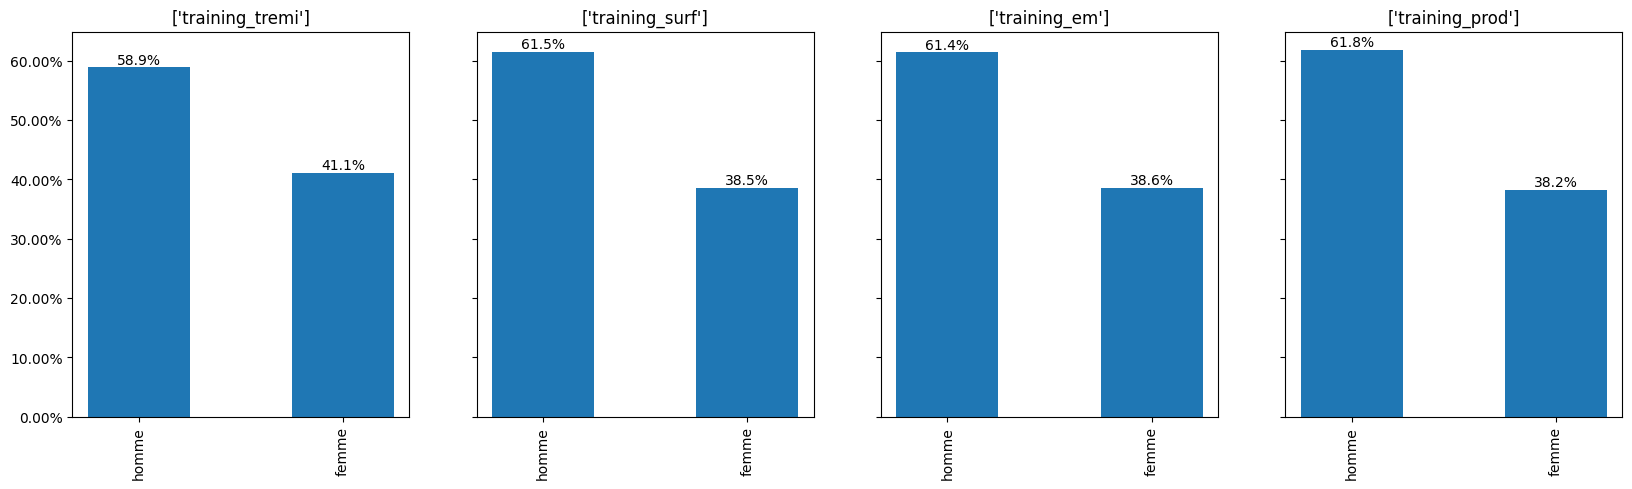

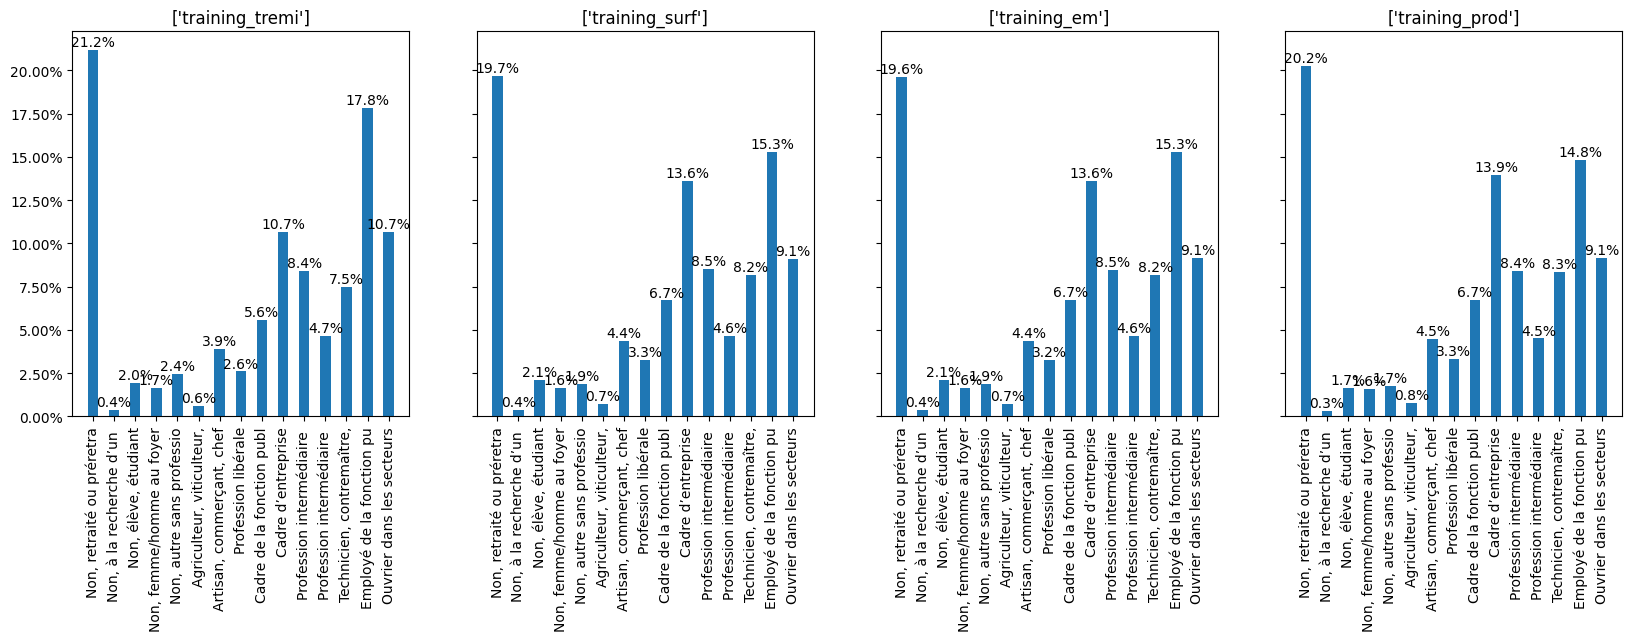

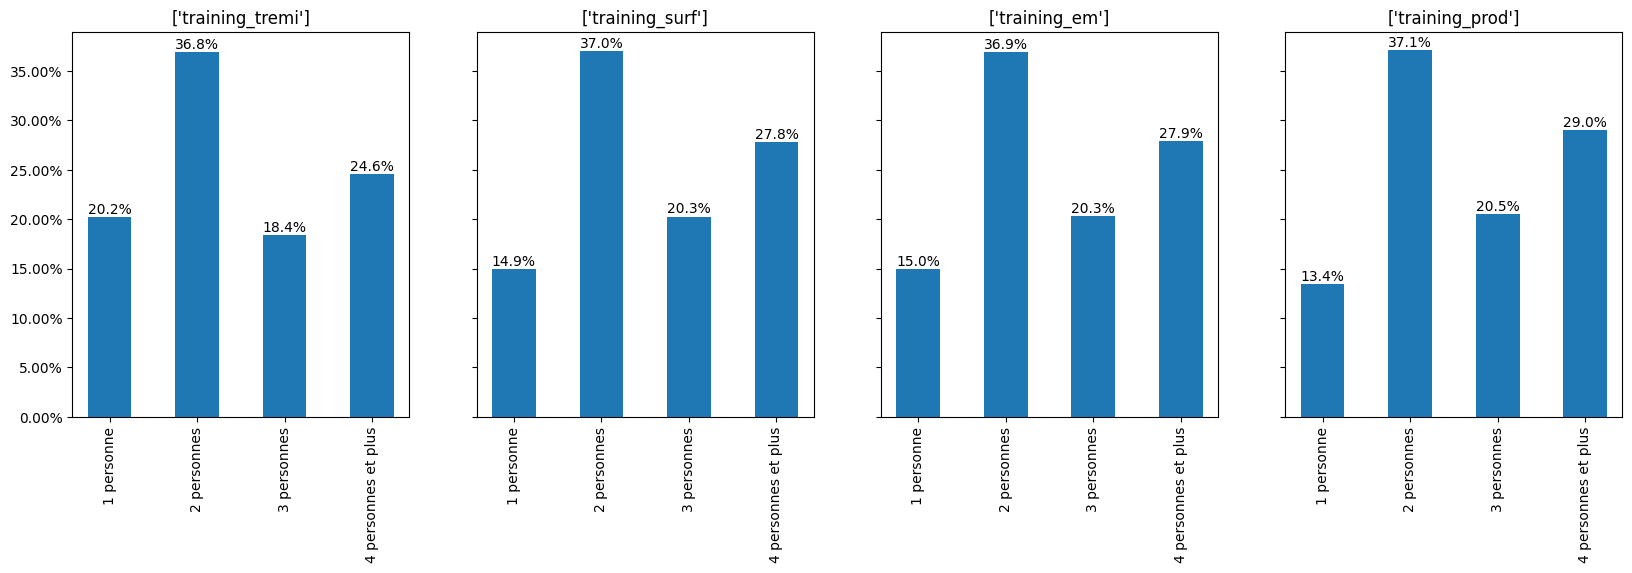

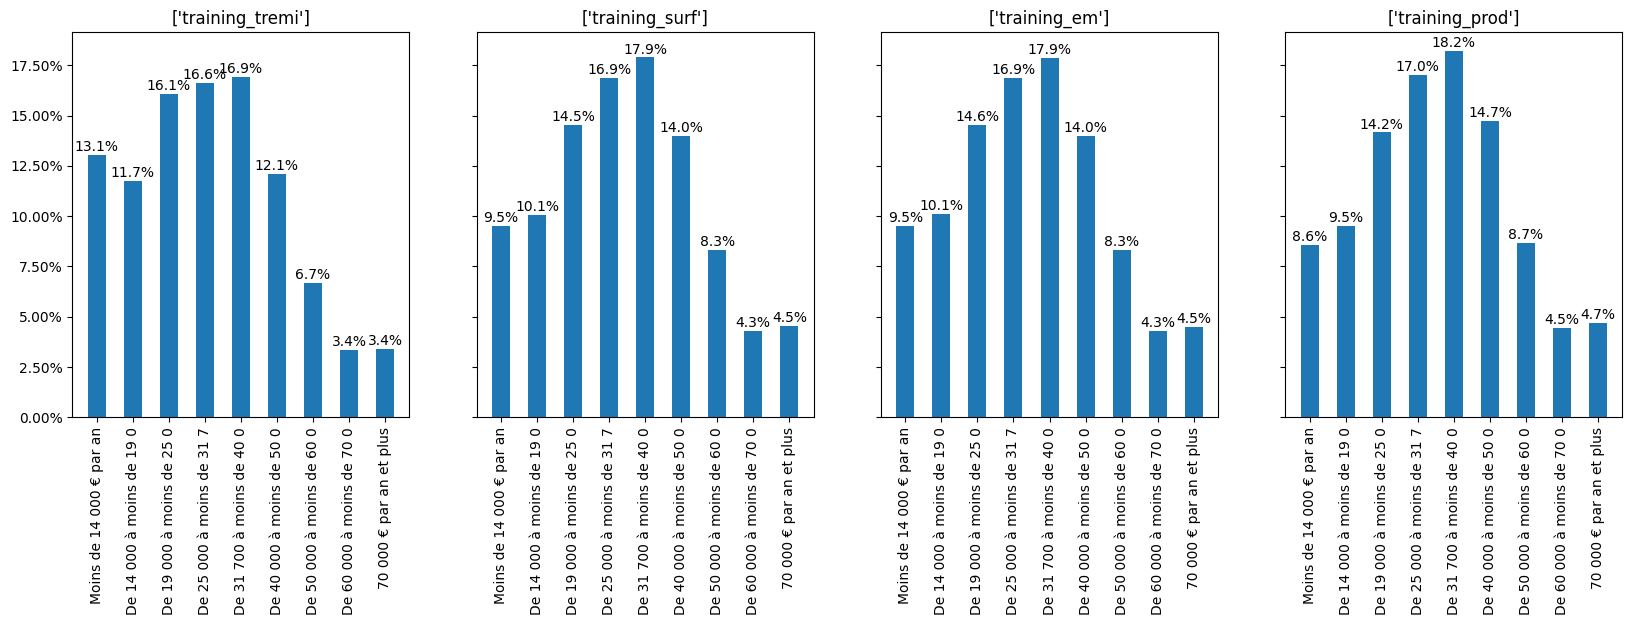

In [153]:
dfs = [training_tremi, training_surf, training_em, training_prod]
compare_repartition(dfs, 'gender')
compare_repartition(dfs, 'occupation')
compare_repartition(dfs, 'nb_persons_home')
compare_repartition(dfs, 'income')

In [129]:
def histo(df, variable, bins = 20):
    plt.title(variable)
    plt.hist(df.select(variable).toPandas(), bins=bins)
    plt.show()

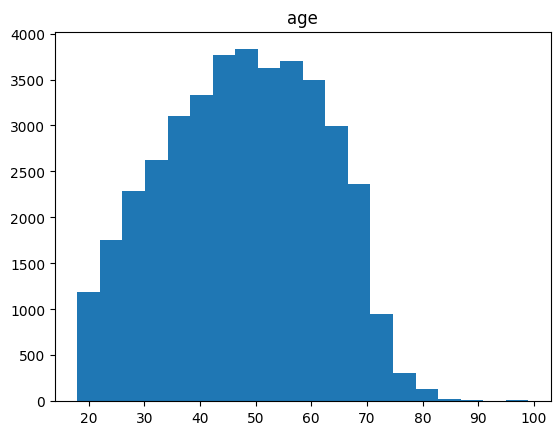

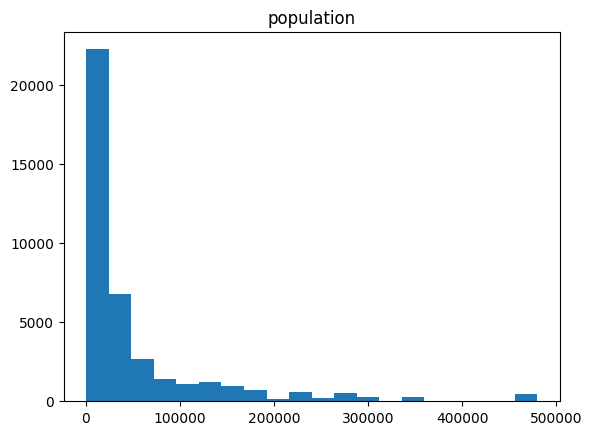

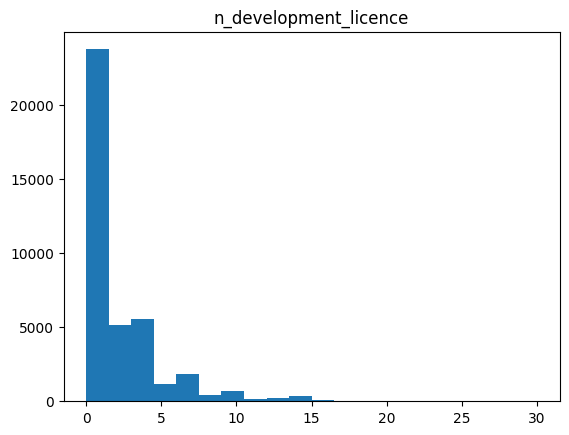

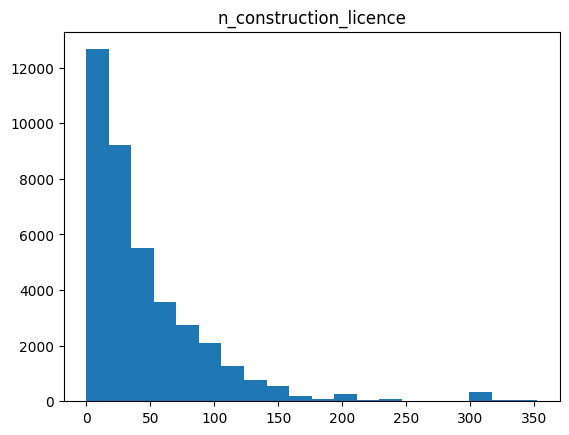

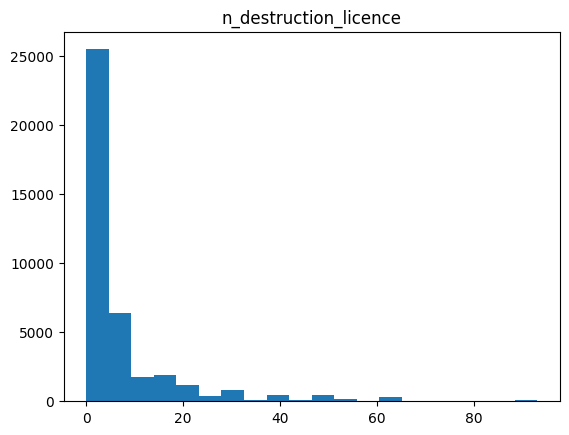

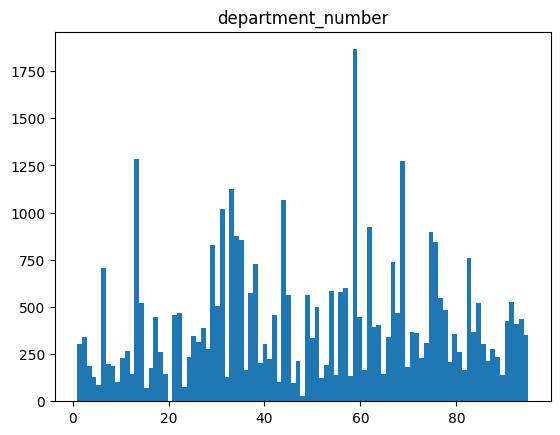

In [130]:
histo(training_tremi, 'age')
histo(training_tremi, 'population')
histo(training_tremi, 'n_development_licence')
histo(training_tremi, 'n_construction_licence')
histo(training_tremi, 'n_destruction_licence')
histo(training_tremi, 'department_number', 95)

# ouput variables

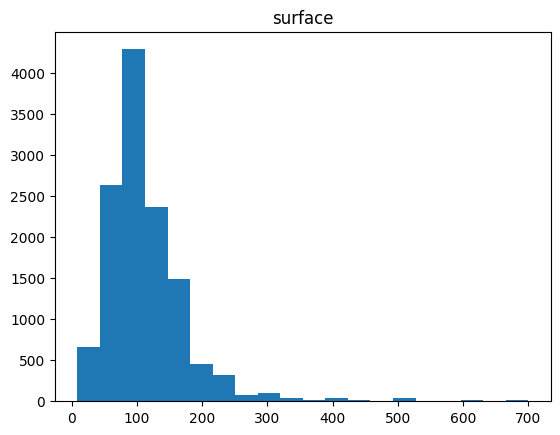

C:\Users\arocheteau\AppData\Local\Temp\ipykernel_18620\2330589533.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


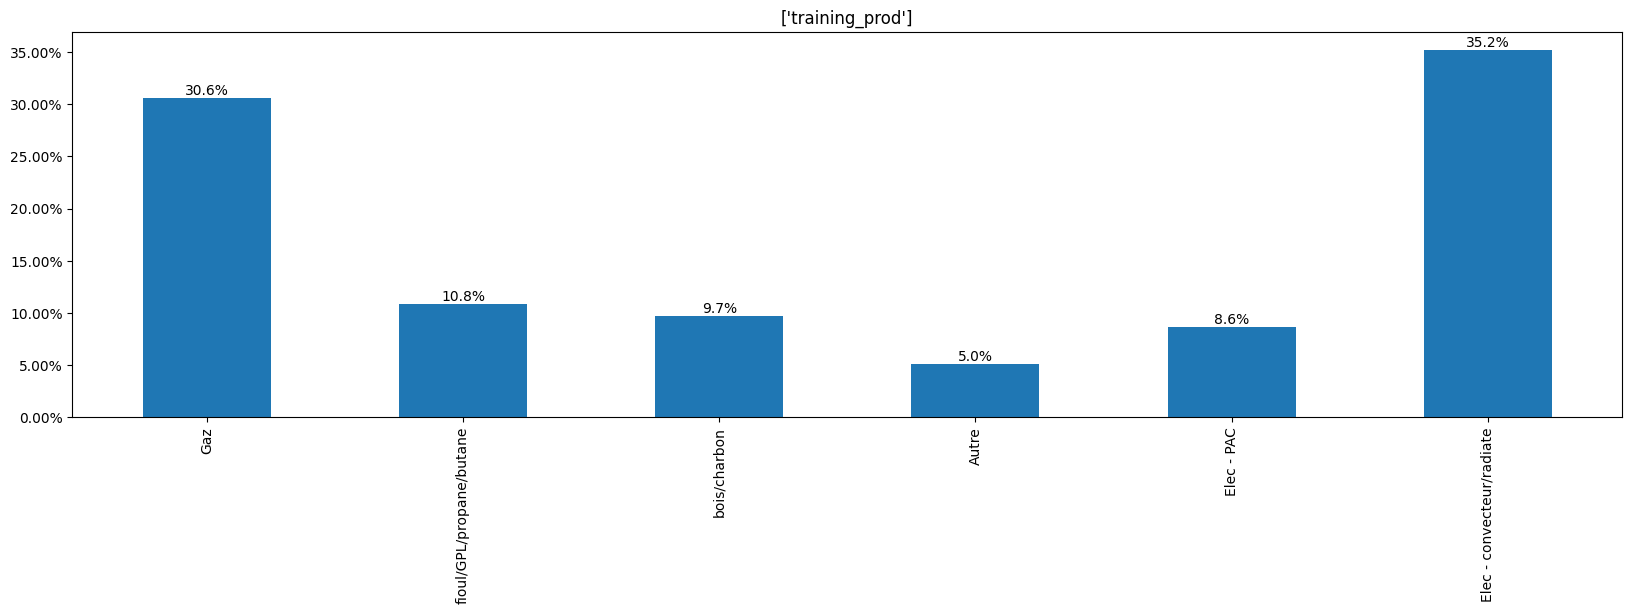

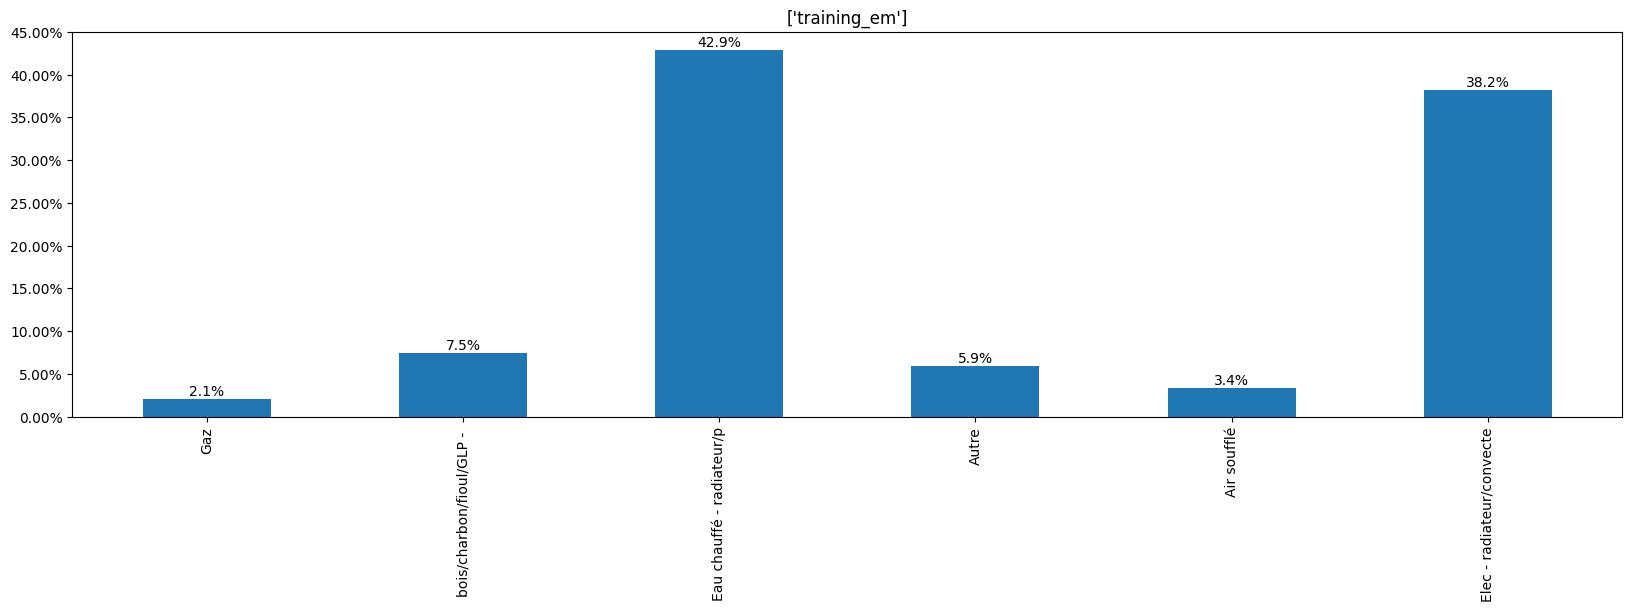

In [131]:
histo(training_surf, 'surface')
compare_repartition([training_prod], 'heating_production')
compare_repartition([training_em], 'heating_emission')

# ML

In [132]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## surface

### regression

In [164]:
def prepare_dataset(df, col_X_hot, col_X_not_hot, col_y, y_hot, scale):
    labels = ['dummy']
    for variable in (col_X_not_hot):
        labels.append(variable)
    for variable in col_X_hot:
        labels.extend(get_labels(variable)['meaning'][1:])
    X_not_hot = df.select(col_X_not_hot).toPandas().to_numpy()
    X_hot = df.select(col_X_hot).toPandas()
    X_hot = OneHotEncoder(drop='first', sparse_output=False).fit_transform(X_hot)
    X = np.column_stack((X_not_hot, X_hot))

    y = df.select(col_y).toPandas().to_numpy()
    if y_hot:
        y = OneHotEncoder(drop='first', sparse_output=False).fit_transform(y)

    # scale data
    if scale:
        X = StandardScaler().fit_transform(X)
        y = StandardScaler().fit_transform(y)
    return (X, y, labels)
    
col_X_hot = ['occupation', 'nb_persons_home', 'income', 'department_number']
col_y = ['surface']
col_X_not_hot = [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot + col_y ]
X, y, labels = prepare_dataset(training_surf, col_X_hot, col_X_not_hot, col_y, False, True)


In [135]:
def least_square(y_true, y_pred):
    return sum([(true[0]-pred[0])**2 for true, pred in zip(y_true, y_pred)])

In [136]:
# add some non_linearity
poly = PolynomialFeatures(1)
X_transformed = poly.fit_transform(X)

# split training and testing 
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.4, random_state=42)

# linear regression
reg = LinearRegression().fit(X_train, y_train)


training_score :  0.20676635454993741
testing_score :  0.1888499342357537
['dummy', 'gender', 'age', 'home_state', 'population', 'n_development_licence', 'n_construction_licence', 'n_new_buildings', 'n_destruction_licence', 'Non, à la recherche d’un ', 'Non, élève, étudiant', 'Non, femme/homme au foyer', 'Non, autre sans professio', 'Agriculteur, viticulteur,', 'Artisan, commerçant, chef', 'Profession libérale', 'Cadre de la fonction publ', 'Cadre d’entreprise', 'Profession intermédiaire ', 'Profession intermédiaire ', 'Technicien, contremaître,', 'Employé de la fonction pu', 'Ouvrier dans les secteurs', '2 personnes', '3 personnes', '4 personnes et plus', 'De 14 000 à moins de 19 0', 'De 19 000 à moins de 25 0', 'De 25 000 à moins de 31 7', 'De 31 700 à moins de 40 0', 'De 40 000 à moins de 50 0', 'De 50 000 à moins de 60 0', 'De 60 000 à moins de 70 0', '70 000 € par an et plus', 'Aisne', 'Allier', 'Alpes-de-Haute-Provence', 'Hautes-Alpes', 'Alpes-Maritimes', 'Ardèche', 'Ardennes', '

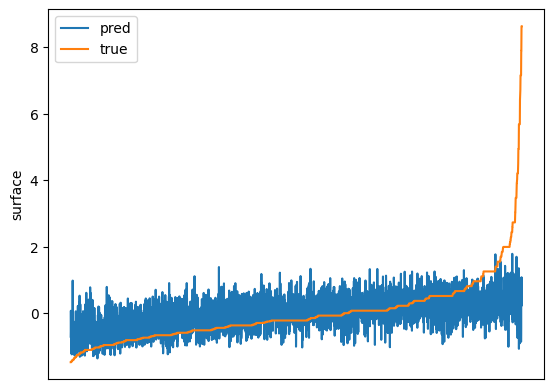

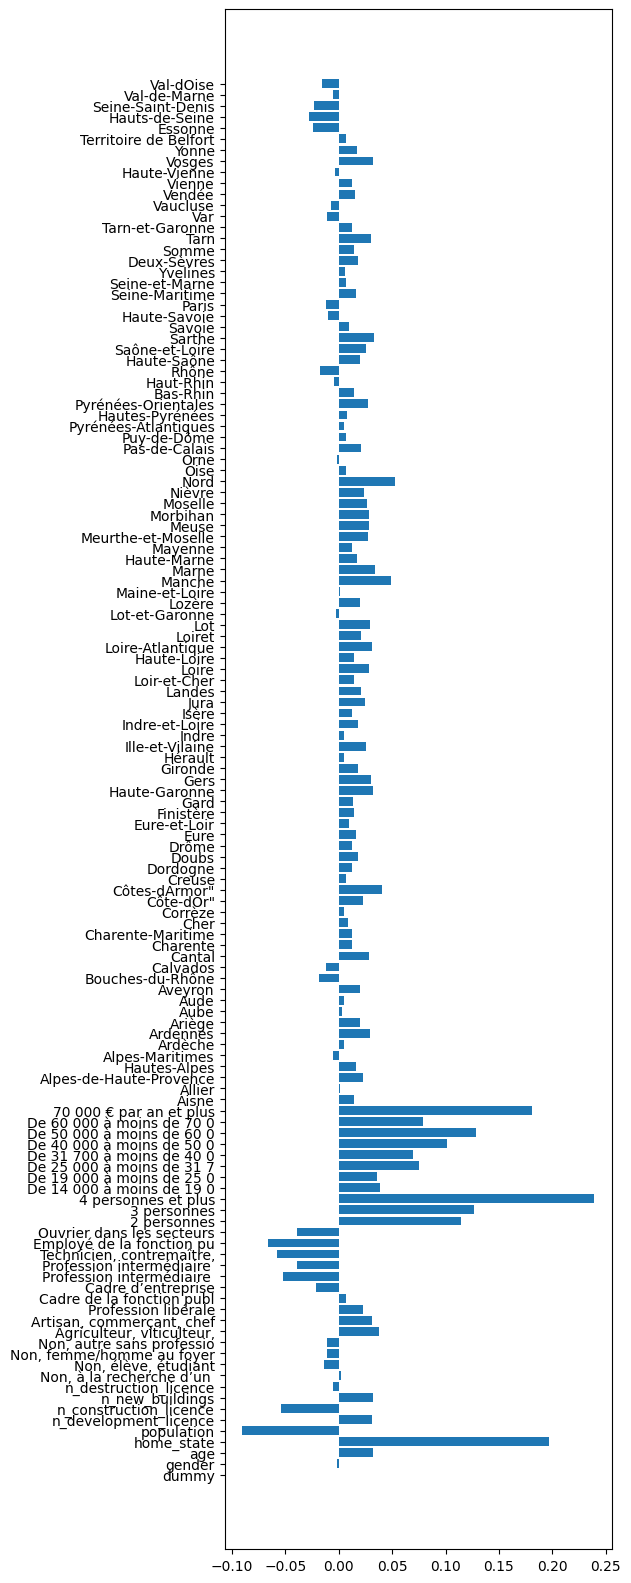

In [168]:
# prediction
y_pred = reg.predict(X_test)
print('training_score : ', reg.score(X_train, y_train))
print('testing_score : ', reg.score(X_test, y_test))


def show_result(y_pred, y_true):
    df = pd.DataFrame(np.column_stack((y_pred, y_true)), columns = ['pred', 'true'])
    df = df.sort_values(by=['true'])
    df.reset_index(inplace = True, drop=True)
    plt.plot(df)
    plt.legend(['pred', 'true'])
    plt.ylabel('surface')
    plt.xticks([])
    plt.show()

def show_importance(reg, labels):
    y_pos = [i for i in range(len(labels))]
    f, ax = plt.subplots(figsize=(5,20))
    ax.barh(y_pos, reg.coef_.T.ravel(), align = 'center')
    ax.set_yticks(y_pos, labels = labels)
    plt.show()

print(labels)
show_result(y_pred, y_test)
show_importance(reg, labels)




### random forest

In [139]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy

In [140]:
col_X_hot = ['occupation', 'nb_persons_home', 'income', 'department_number']
col_y = ['surface']
col_X_not_hot = [col[0] for col in training_surf.dtypes if col[0] not in col_X_hot + col_y ]
X, y = prepare_dataset(training_surf, col_X_hot, col_X_not_hot, col_y, False, True)

In [141]:
def iterate_params(current, max_hyper):
    for i, (max, curr) in enumerate(zip(max_hyper, current)):
        if max == curr:
            current[i] = 0
        else:
            current[i] += 1
            break
    return current

def choose_params(current, hyperparams):
    hyper = {}
    for hyper_nb, (hyper_name, hyper_choices) in zip(current, hyperparams.items()):
        hyper[hyper_name] = hyper_choices[hyper_nb]
    return hyper

def nb_possibility(max_hyper):
    total = 1
    for nb_poss in max_hyper:
        total *= (nb_poss + 1)
    return total
    
def train_hyper(hyperparams, X_train, X_test, y_train, y_test):
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    scores = {}

    # params choice
    current = [0 for _ in range(len(hyperparams))]
    max_hyper = [len(hyperparam) - 1 for hyperparam in hyperparams.values()]
    current_params = choose_params(current, hyperparams)
    all_poss = nb_possibility(max_hyper)

    # training model
    forest_regr = RandomForestRegressor(**current_params)
    forest_regr.fit(X_train, y_train)

    # register score
    best_score = forest_regr.score(X_test, y_test)
    best_params = current_params.copy()
    scores[(param for param in current_params)] = forest_regr.score(X_test, y_test)

    print(all_poss)
    i = 0
    nb_print = all_poss//5
    while not all(np.equal(current, max_hyper)):
        # choose params
        current = iterate_params(current, max_hyper)
        current_params = choose_params(current, hyperparams)
        if i % nb_print == 0:
            print(i, current)
        i += 1
        forest_regr = RandomForestRegressor(**current_params)
        forest_regr.fit(X_train, y_train)
        scores[(param for param in current_params)] = forest_regr.score(X_test, y_test)
        if forest_regr.score(X_test, y_test) > best_score:
            best_score = forest_regr.score(X_test, y_test)
            best_params = current_params.copy()
            best_model = deepcopy(forest_regr)
    return (best_model, best_score, best_params, scores)


In [142]:
# add some non_linearity
poly = PolynomialFeatures(1)
X_transformed = poly.fit_transform(X)

# split training and testing 
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.4, random_state=42)

hyperparams = {
    'n_estimators' : [50,100,200],
    # 'criterion' : ["squared_error", "absolute_error", "friedman_mse"],
    'max_depth' : [2,10,20,50,None],
    # 'min_samples_split' : [2,5,10],
    # 'min_samples_leaf' : [1,2,3],
    # 'max_features' : ["sqrt", "log2", "auto"]
}

best_model, best_score, best_params, scores = train_hyper(hyperparams, X_train, X_test, y_train, y_test)
print(best_score, best_params)

15
0 [1, 0]
3 [1, 1]
6 [1, 2]
9 [1, 3]
12 [1, 4]
0.18762209086464132 {'n_estimators': 100, 'max_depth': 50}


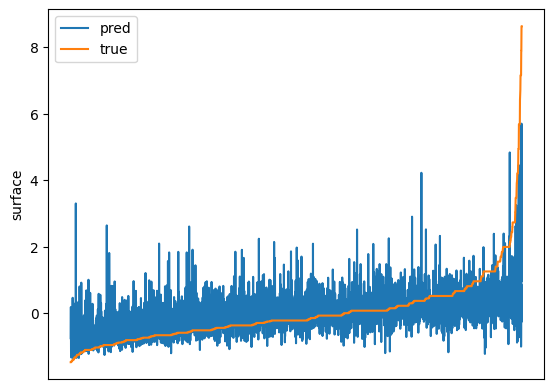

In [143]:
y_pred = best_model.predict(X_test)
show_result(y_pred, y_test)


In [144]:
print(best_model.feature_importances_)

[0.         0.01156619 0.11724254 0.09732316 0.10288512 0.02945648
 0.05430934 0.05704279 0.04214556 0.00074797 0.00290178 0.00170443
 0.00154064 0.00648596 0.01221597 0.00932583 0.01132796 0.01101927
 0.0033196  0.00427048 0.00847263 0.00829114 0.0090583  0.01025939
 0.01041291 0.02401128 0.00968696 0.01013941 0.01495933 0.00850773
 0.0085398  0.01330458 0.00777309 0.02437009 0.00198551 0.00063255
 0.00134695 0.00154466 0.00787317 0.00043168 0.005658   0.00149359
 0.00088686 0.00054759 0.00063777 0.00649466 0.00085419 0.001383
 0.00110006 0.00092684 0.00223393 0.00091446 0.00243488 0.00728837
 0.00036691 0.00081811 0.00223813 0.00314281 0.00390403 0.00103347
 0.00257201 0.00249951 0.00146117 0.00341068 0.00440643 0.0039466
 0.0032093  0.00067322 0.0051452  0.00651924 0.00653078 0.00263309
 0.00182589 0.00608558 0.0002511  0.00745332 0.00529541 0.00202663
 0.00035845 0.0001577  0.00150547 0.00537275 0.00463538 0.00070942
 0.00138949 0.00352522 0.00188999 0.0056204  0.00249217 0.0018246

### XG boost